<a href="https://colab.research.google.com/github/jaeeyun103/weather_heat/blob/main/%EB%B6%84%EC%84%9D%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%A8%EC%BD%94%EB%93%9C%5B250234%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본설정

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Path 설정하기
path = '/content/drive/MyDrive/weather/'

In [ ]:
!pip install linearmodels xgboost scikit-learn pandas numpy
!pip install ace_tools
!pip install linearmodels
!pip install statsmodels matplotlib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# 코드실행시 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')



*   train_heat.csv불러오기 이전에 열이름을 excel에서 읽기 쉽게 바꿈 (ex. si, ta, ta_chi 등)



In [ ]:
df_heat=pd.read_csv(path+'train_heat.csv') # (499301, 12)

## df_heat

In [ ]:
df_heat = df_heat.drop('Unnamed: 0', axis=1)

In [ ]:
# tm열 datetime 타입으로 변경
df_heat['tm'] = pd.to_datetime(df_heat['tm'], format='%Y%m%d%H')

## test_heat

In [ ]:
test_heat = pd.read_csv(path+'test_heat.csv')

In [ ]:
test_heat.shape

(166915, 11)

In [ ]:
num_rows_with_minus99 = (test_heat == -99).any(axis=1).sum()

# 전체 행 개수
total_rows = len(test_heat)

# 비율 계산
ratio = num_rows_with_minus99 / total_rows * 100

print(f"-99가 포함된 행 개수: {num_rows_with_minus99}개")
print(f"전체 대비 비율: {ratio:.2f}%")

-99가 포함된 행 개수: 81663개
전체 대비 비율: 48.92%


In [ ]:
# test데이터의 열 이름 변경
test_heat.columns = [
    "tm",          # 시간
    "branch_id",   # 지점 ID
    "ta",          # 기온
    "wd",          # 풍향
    "ws",          # 풍속
    "rn_day",      # 일강수량
    "rn_hr1",      # 시간당 강수량
    "hm",          # 습도
    "si",          # 일조
    "ta_chi",      # 체감온도
    "heat_demand"  # 난방수요
]

In [ ]:
# tm열 datetime 타입으로 변경
test_heat['tm'] = pd.to_datetime(test_heat['tm'], format='%Y%m%d%H')

In [ ]:
# 각 열별로 -99 값이 있는 개수를 저장할 딕셔너리 생성
test_99_counts = {}

# 데이터프레임의 각 열을 순회
for column in test_heat.columns:
    # 해당 열에서 값이 -99인 요소의 개수를 계산
    count = (test_heat[column] == -99).sum()
    # 딕셔너리에 저장
    test_99_counts[column] = count

# 결과 출력
for column, count in test_99_counts.items():
    print(f"'{column}' 열의 -99 값: {count}")

'tm' 열의 -99 값: 0
'branch_id' 열의 -99 값: 0
'ta' 열의 -99 값: 2355
'wd' 열의 -99 값: 4806
'ws' 열의 -99 값: 4806
'rn_day' 열의 -99 값: 4411
'rn_hr1' 열의 -99 값: 4590
'hm' 열의 -99 값: 5875
'si' 열의 -99 값: 75754
'ta_chi' 열의 -99 값: 1
'heat_demand' 열의 -99 값: 0


In [ ]:
test_heat.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2024-01-01 00:00:00,A,0.5,171.3,0.8,2.5,0.0,97.1,-99.0,0.3,NaN
1,2024-01-01 01:00:00,A,0.4,93.7,1.0,0.0,0.0,96.8,-99.0,0.1,NaN
2,2024-01-01 02:00:00,A,-0.1,133.0,0.8,0.0,0.0,97.0,-99.0,0.0,NaN
3,2024-01-01 03:00:00,A,-0.8,218.6,0.6,0.0,0.0,96.9,-99.0,-0.2,NaN
4,2024-01-01 04:00:00,A,0.1,58.7,1.5,0.0,0.0,97.0,-99.0,-0.1,NaN


## df_heat와 test_heat 데이터를 concat

In [ ]:
df = pd.concat([df_heat, test_heat], axis=0).sort_values("tm")

In [ ]:
df.shape

(666216, 11)

In [ ]:
df.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281.0
473022,2021-01-01 01:00:00,S,-8.9,360.0,0.0,0.0,0.0,86.7,-99.0,-9.5,13.0
78837,2021-01-01 01:00:00,D,-7.0,282.3,0.9,0.0,0.0,-99.0,-99.0,-8.1,382.0
105116,2021-01-01 01:00:00,E,-7.0,282.3,0.9,0.0,0.0,-99.0,-99.0,-8.1,115.0
446743,2021-01-01 01:00:00,R,-3.9,15.9,1.9,0.0,0.0,92.4,-99.0,-6.0,37.0


# df전처리

In [ ]:
# month, day, hour, weekday 파생변수 추가
df['month'] = df['tm'].dt.month
df['day'] = df['tm'].dt.day
df['hour'] = df['tm'].dt.hour
df['weekday'] = df['tm'].dt.dayofweek # 요일 변수 추가 (월=0, 일=6)


# 파생변수 위치 조정
cols = df.columns.tolist()
cols.insert(cols.index('tm') + 1, cols.pop(cols.index('month')))
cols.insert(cols.index('tm') + 2, cols.pop(cols.index('day')))
cols.insert(cols.index('tm') + 3, cols.pop(cols.index('hour')))
cols.insert(cols.index('tm') + 4, cols.pop(cols.index('weekday')))
df = df[cols]

df.head()

,tm,month,day,hour,weekday,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021-01-01 01:00:00,1,1,1,4,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281.0
473022,2021-01-01 01:00:00,1,1,1,4,S,-8.9,360.0,0.0,0.0,0.0,86.7,-99.0,-9.5,13.0
78837,2021-01-01 01:00:00,1,1,1,4,D,-7.0,282.3,0.9,0.0,0.0,-99.0,-99.0,-8.1,382.0
105116,2021-01-01 01:00:00,1,1,1,4,E,-7.0,282.3,0.9,0.0,0.0,-99.0,-99.0,-8.1,115.0
446743,2021-01-01 01:00:00,1,1,1,4,R,-3.9,15.9,1.9,0.0,0.0,92.4,-99.0,-6.0,37.0


* 상관계수 확인




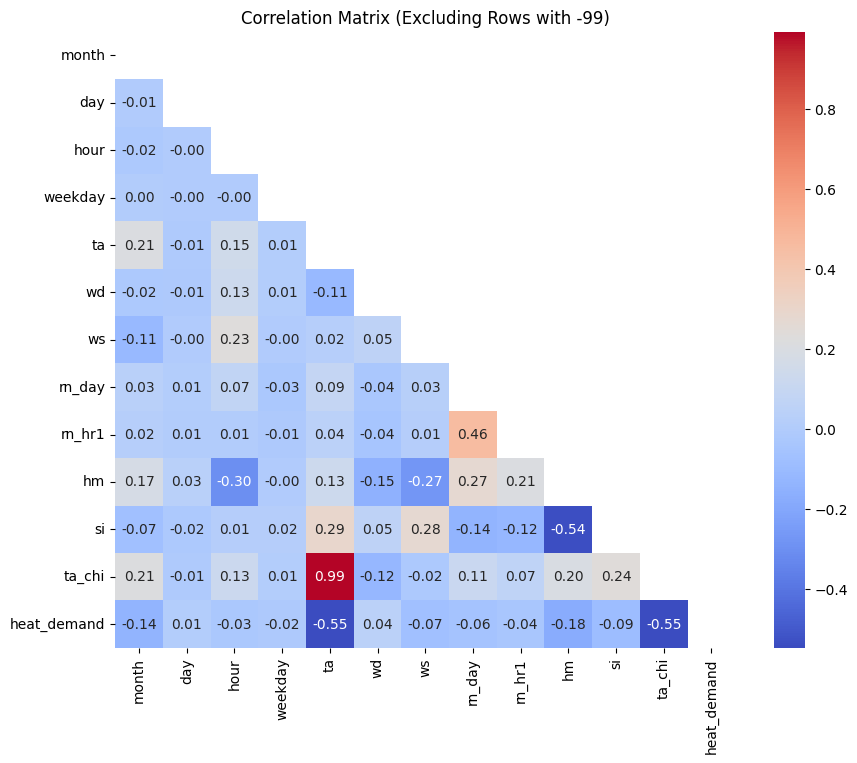

In [ ]:
# # -99 값이 있는 행을 제외한 데이터프레임 생성
df_no_neg_99_rows = df[(df != -99).all(axis=1)].copy()

# # 숫자형 변수만 선택
numerical_df_no_neg_99_rows = df_no_neg_99_rows.select_dtypes(include=np.number)

# # 상관 행렬 계산
correlation_matrix_no_neg_99_rows = numerical_df_no_neg_99_rows.corr()

# # 상관 행렬의 하삼각 행렬을 생성 (대각선 포함)
mask = np.triu(np.ones_like(correlation_matrix_no_neg_99_rows, dtype=bool))

# # 상관 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_neg_99_rows, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Matrix (Excluding Rows with -99)')
plt.show()

* 시계열 데이터 분해

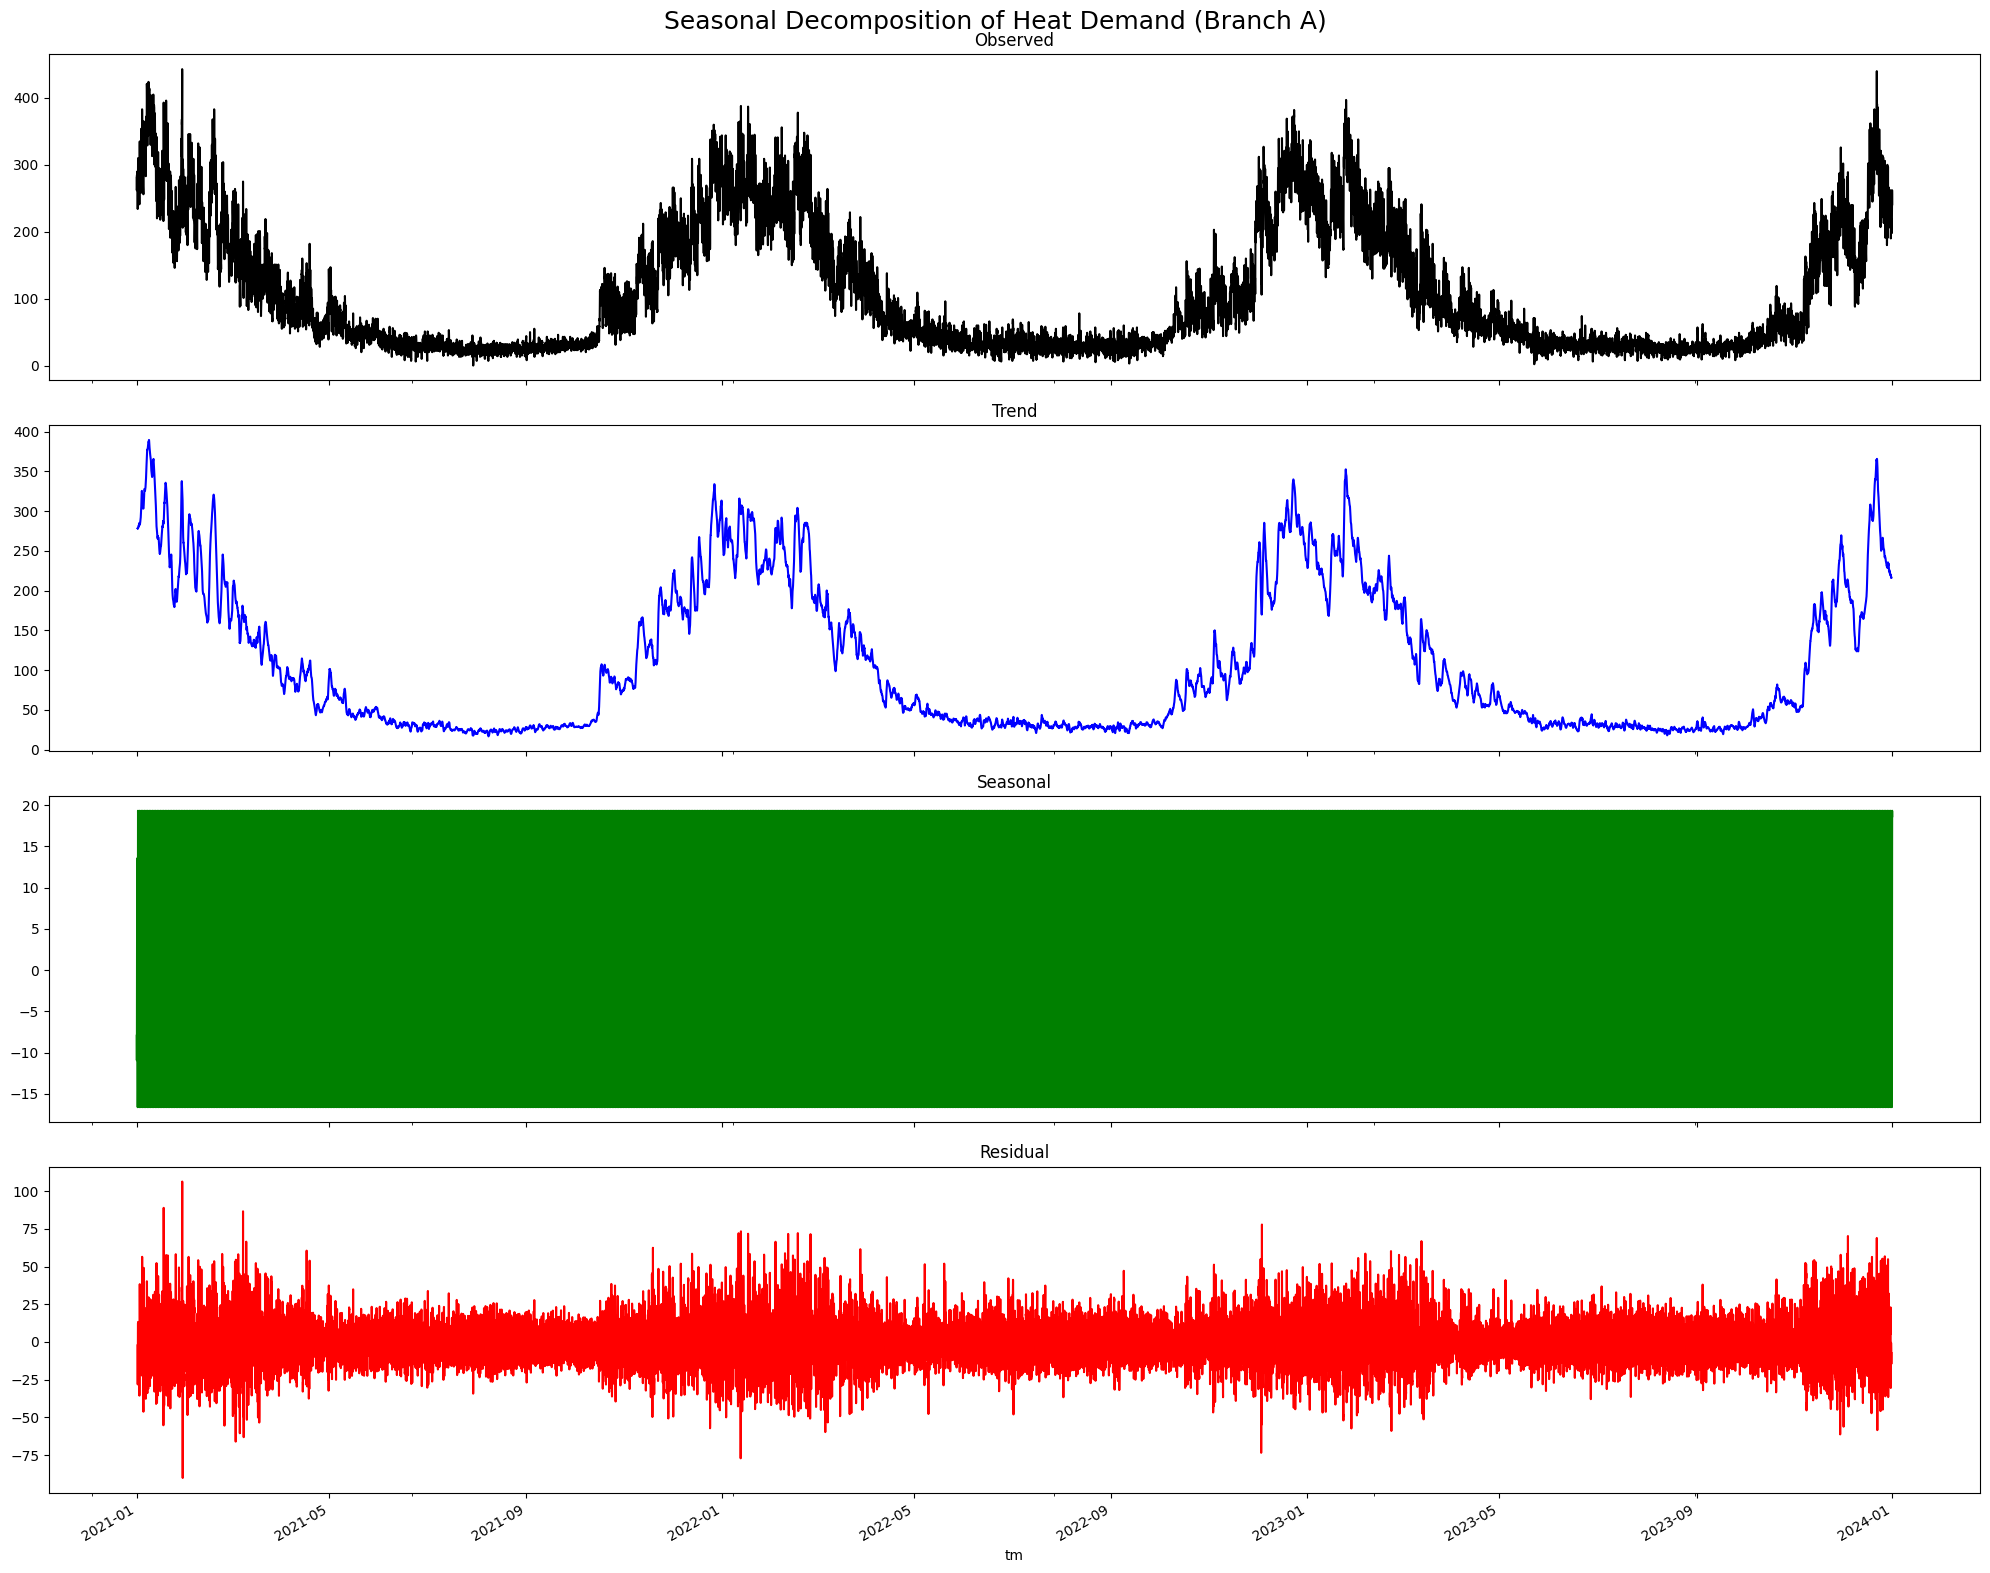

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# A 지역 필터링 및 이상치 제거
df_A = df[df['branch_id'] == 'A']

# 시간 인덱스 설정 (datetime이 아니면 변환 필요)
df_A['tm'] = pd.to_datetime(df_A['tm'])
df_A.set_index('tm', inplace=True)
55
series = df_A['heat_demand']
series = series[series != -99].dropna() # 이상치 제거

# seasonal_decompose 적용
decompose_result = seasonal_decompose(series, model='additive', period=24)

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(20, 16), sharex=True)

decompose_result.observed.plot(ax=axes[0], title='Observed', color='black')
decompose_result.trend.plot(ax=axes[1], title='Trend', color='blue')
decompose_result.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
decompose_result.resid.plot(ax=axes[3], title='Residual', color='red')

plt.suptitle("Seasonal Decomposition of Heat Demand (Branch A)", fontsize=18)
plt.tight_layout()
plt.show()

* 극좌표

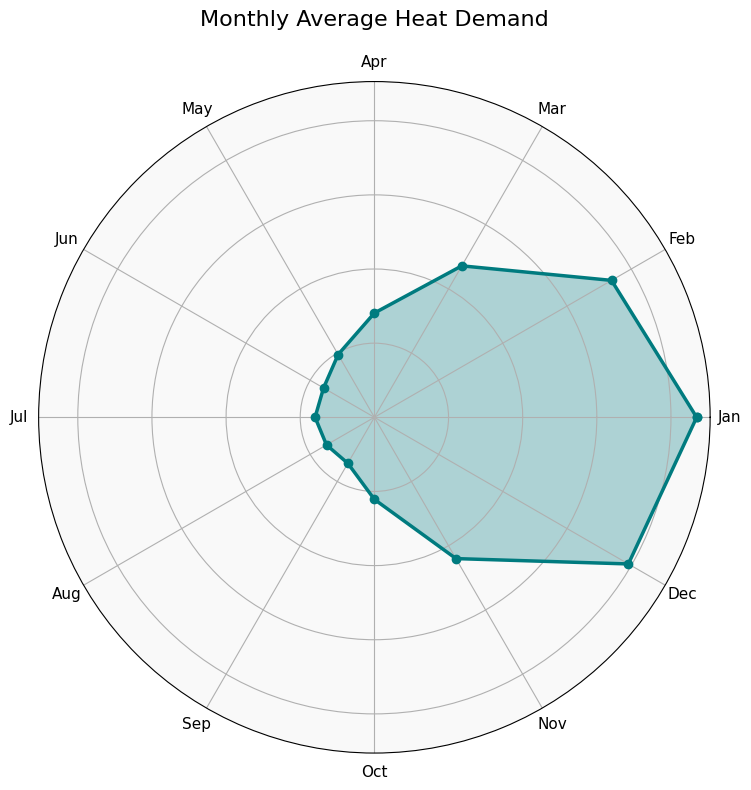

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -99 이상치 제거
df_valid = df[df['heat_demand'] != -99]

# 월별 평균 heat_demand 계산
monthly_mean = df_valid.groupby('month')['heat_demand'].mean()

# 각도 계산
months = np.arange(1, 13)
angles = np.deg2rad((months - 1) * 360 / 12)

# wrap-around
values = monthly_mean.values
values = np.append(values, values[0])
angles = np.append(angles, angles[0])

# 스타일 지정
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_facecolor('#f9f9f9')

# 그래프 선과 채움
ax.plot(angles, values, marker='o', linewidth=2.5, color='#007b7f', label='Average Heat Demand')
ax.fill(angles, values, alpha=0.3, color='#007b7f')

# 월 라벨
ax.set_xticks(np.deg2rad(np.linspace(0, 330, 12)))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=11)

# y축 숨기기
ax.set_yticklabels([])
ax.set_rlabel_position(270)

# 제목과 그래프 간격 조정
ax.set_title('Monthly Average Heat Demand', fontsize=16, pad=40)

plt.tight_layout()
plt.show()

## si(일사량)열에 대해서 season(계절)과 hour(시간) 조건에 따른 보간


*   Train(21,22,23)
*   Test(24)


In [ ]:
# si열에 대해서 월별 일사량에 대해서 si값이 -99인 경우, 계절에 따라 일사량을 0으로 간주

# 봄 조건 (3~5월, 6시 이전 또는 19시 이후) - Adjusted based on 06:02 / 19:07
spring_cond = (df['month'].between(3, 5)) & ((df['hour'] <= 6) | (df['hour'] >= 19))

# 여름 조건 (6~9월, 5시 이전 또는 19시 이후) - Adjusted based on 05:35 / 19:31
summer_cond = (df['month'].between(6, 9)) & ((df['hour'] <= 5) | (df['hour'] >= 20))

# 가을 조건 (10~11월, 7시 이전 또는 18시 이후) - Adjusted based on 06:55 / 17:38
autumn_cond = (df['month'].between(10, 11)) & ((df['hour'] <= 6) | (df['hour'] >= 18))

# 겨울 조건 (12, 1, 2월, 7시 이전 또는 18시 이후) - Adjusted based on 07:32 / 17:48
winter_cond = (df['month'].isin([12, 1, 2])) & ((df['hour'] <= 7) | (df['hour'] >= 18))

# 조건 만족 + si가 -99인 경우 -> si를 0으로 변경
df.loc[((summer_cond | winter_cond | spring_cond | autumn_cond) & (df['si'] == -99)), 'si'] = 0

## P열과 기상환경이 유사한 열에서 si값 가져오기
df 데이터프레임에서 'ta', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi', 'heat_demand' 열을 기준으로, 'P' 지점(branch)과 가장 유사한 날씨 환경을 가진 다른 지점을 찾아라.

### 데이터 준비


데이터셋에서 관련된 기상 변수들과 'branch_id'만 포함되도록 필터링
필요하다면 결측값도 처리


지정된 날씨 관련 열들과 branch_id만 포함하는 새로운 데이터프레임을 생성한 뒤, 결측값이 있는지 확인하고 이를 처리



In [ ]:
# 관련된 열만 포함하는 새로운 데이터프레임 생성
df_weather = df[['branch_id', 'ta', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi', 'heat_demand']].copy()

# 결측치 처리 전 확인
print("결측치 처리 전:")
print(df_weather.isnull().sum())

# -99를 NaN으로 대체한 후 결측치가 있는 행 제거
# 이유: 이전 분석에서 여러 열에 -99가 많이 포함되어 있어,
# 유사도 비교에 적합하지 않은 불완전한 데이터일 가능성이 높기 때문
df_weather.replace(-99, np.nan, inplace=True)
df_weather.dropna(inplace=True)

# 결측치 처리 후 확인
print("\n결측치 처리 후:")
print(df_weather.isnull().sum())

# 상위 5개 행 출력
display(df_weather.head())

결측치 처리 전:
branch_id           0
ta                  0
ws                  0
rn_day              0
rn_hr1              0
hm                  0
ta_chi              0
heat_demand    166915
dtype: int64

결측치 처리 후:
branch_id      0
ta             0
ws             0
rn_day         0
rn_hr1         0
hm             0
ta_chi         0
heat_demand    0
dtype: int64


,branch_id,ta,ws,rn_day,rn_hr1,hm,ta_chi,heat_demand
0,A,-10.1,0.5,0.0,0.0,68.2,-8.2,281.0
2,C,-7.2,0.6,0.0,0.0,57.5,-8.1,663.0
5,F,-10.5,0.3,0.0,0.0,71.6,-10.4,159.0
6,G,-8.0,1.6,0.0,0.0,58.8,-8.5,625.0
7,H,-8.0,1.6,0.0,0.0,58.8,-8.5,328.0


선택된 기상 변수들을 기준으로, 지점 'P'와 다른 모든 지점들 간의 유사도 점수(similarity score)를 계산하라.
이때, 각 지점의 시간에 따른 변수 값들을 비교하여 상관관계(correlation) 또는 거리(metric, 예: 유클리드 거리) 등을 사용할 수 있다


기상 변수들을 정의하고, 지점 'P'의 데이터를 필터링한 후,
다른 지점들을 순회(iterate) 하며
시간에 따른 해당 변수들의 상관관계(correlation) 를 기반으로
유사도 점수를 계산하고 저장



In [ ]:
# 1. 비교할 기상 변수 목록 정의
weather_vars = ['ta', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi', 'heat_demand']

# 2. 지점 'P'에 해당하는 데이터프레임 생성
df_p = df_weather[df_weather['branch_id'] == 'P'].copy()

# 3. 유사도 점수를 저장할 딕셔너리 초기화
similarity_scores = {}

# 전체 지점 목록 가져오기
all_branches = df_weather['branch_id'].unique()

# 4. 'P'를 제외한 다른 지점들을 하나씩 순회
for branch in all_branches:
    if branch != 'P':
        # 5. 현재 지점(branch)의 데이터프레임 생성
        df_current_branch = df_weather[df_weather['branch_id'] == branch].copy()

        # 6. 'tm' 컬럼 기준으로 지점 P와 현재 지점의 데이터를 병합
        # 참고: df_weather에는 'tm'이 없을 수 있으므로 원본 df에서 가져옴
        df_p_original = df[df['branch_id'] == 'P'].copy()
        df_current_branch_original = df[df['branch_id'] == branch].copy()

        merged_df = pd.merge(
            df_p_original[['tm'] + weather_vars],
            df_current_branch_original[['tm'] + weather_vars],
            on='tm',
            suffixes=('_P', f'_{branch}')
        )

        # 병합 후 NaN이 있는 행은 제거
        merged_df.dropna(inplace=True)

        # 7. 각 변수별 피어슨 상관계수 계산
        correlations = []
        for var in weather_vars:
            correlation = merged_df[f'{var}_P'].corr(merged_df[f'{var}_{branch}'])
            correlations.append(correlation)

        # 상관계수 평균을 유사도 점수로 사용
        # (공통 시간이 없는 경우 NaN으로 처리)
        if correlations:
            average_correlation = np.nanmean(correlations)  # NaN이 있어도 평균 계산 가능하도록 처리
            similarity_scores[branch] = average_correlation
        else:
            similarity_scores[branch] = np.nan  # 공통 시간이 없어 상관계수 계산 불가한 경우

# 8. similarity_scores 딕셔너리에 각 지점과의 유사도 점수 저장 완료

# 결과 출력
print("지점 P와의 유사도 점수 (평균 피어슨 상관계수 기준):")
for branch, score in similarity_scores.items():
    print(f"지점 {branch}: {score:.4f}")


지점 P와의 유사도 점수 (평균 피어슨 상관계수 기준):
지점 A: 0.6245
지점 C: 0.5852
지점 F: 0.2699
지점 G: 0.5620
지점 H: 0.5590
지점 J: 0.5035
지점 L: 0.6076
지점 M: 0.5292
지점 O: 0.7247
지점 R: 0.5970
지점 S: 0.4782
지점 B: 0.4917
지점 D: 0.3321
지점 E: 0.3085
지점 K: 0.3846
지점 I: 0.5700
지점 Q: 0.5502
지점 N: 0.5615


지점 'P'와 유사도 점수가 가장 높은 지점(branch)이 어디인지 결정




가장 높은 유사도 점수를 가진 지점(branch)을 찾아서 결과를 출력



In [ ]:
# 유사도 점수가 가장 높은 지점 찾기
most_similar_branch = max(similarity_scores, key=similarity_scores.get)
highest_similarity_score = similarity_scores[most_similar_branch]

# 결과 출력
print(f"\nBranch with the highest similarity score to Branch P: {most_similar_branch}")
print(f"Highest similarity score: {highest_similarity_score:.4f}")


Branch with the highest similarity score to Branch P: O
Highest similarity score: 0.7247


### 검증

지점 'P'와 가장 유사한 것으로 식별된 지점('O')의 날씨 패턴을 시각화하거나 통계적으로 비교하여 유사성을 확인하라.


데이터프레임에서 지점 'P'와 'O'만 필터링한 후,
지정된 기상 변수들에 대해 시계열 그래프(time series plots)를 생성하여 시각적으로 패턴을 비교
또한, 두 지점의 해당 변수들에 대한 기술 통계(descriptive statistics) 도 계산하여 출력



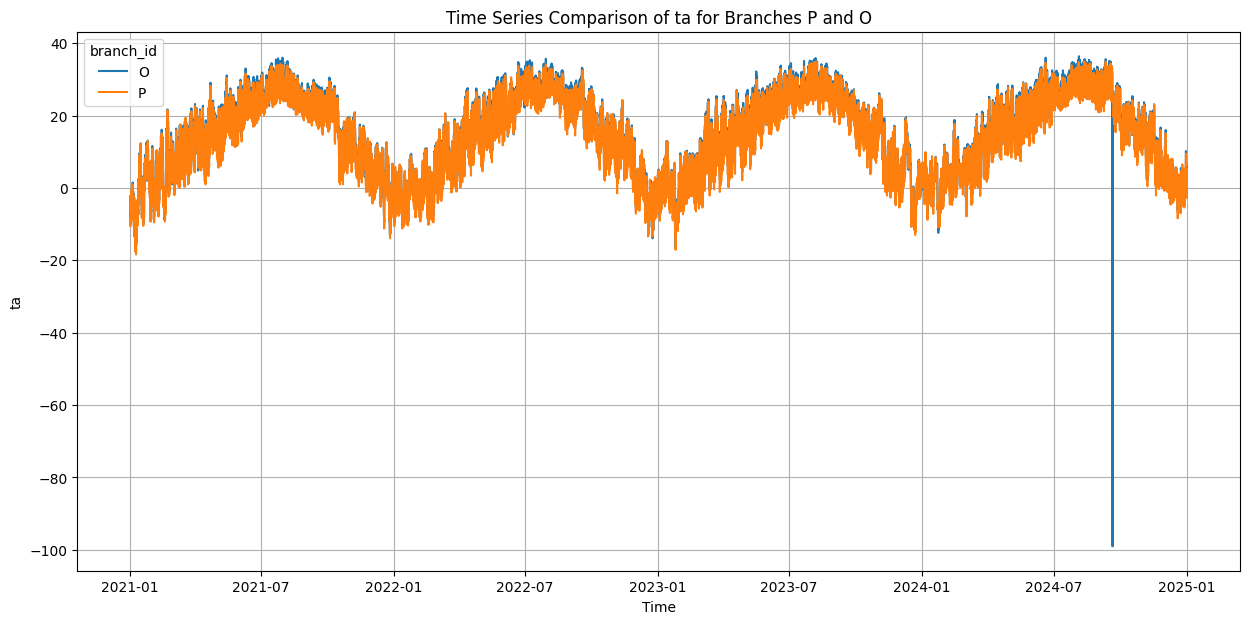

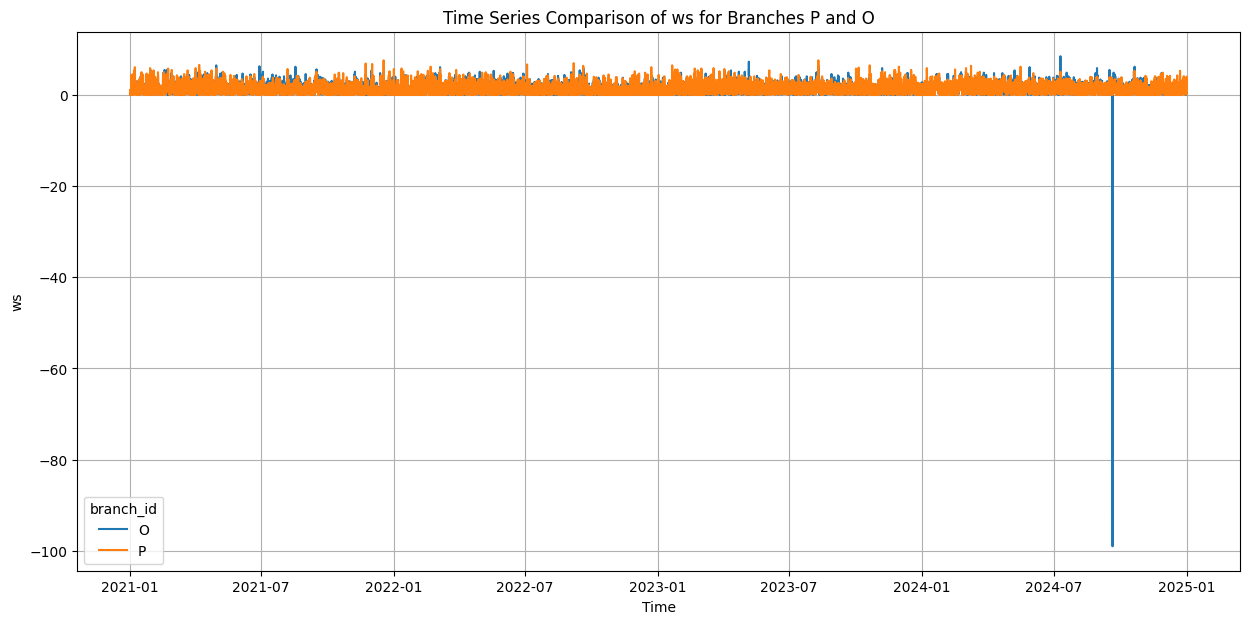

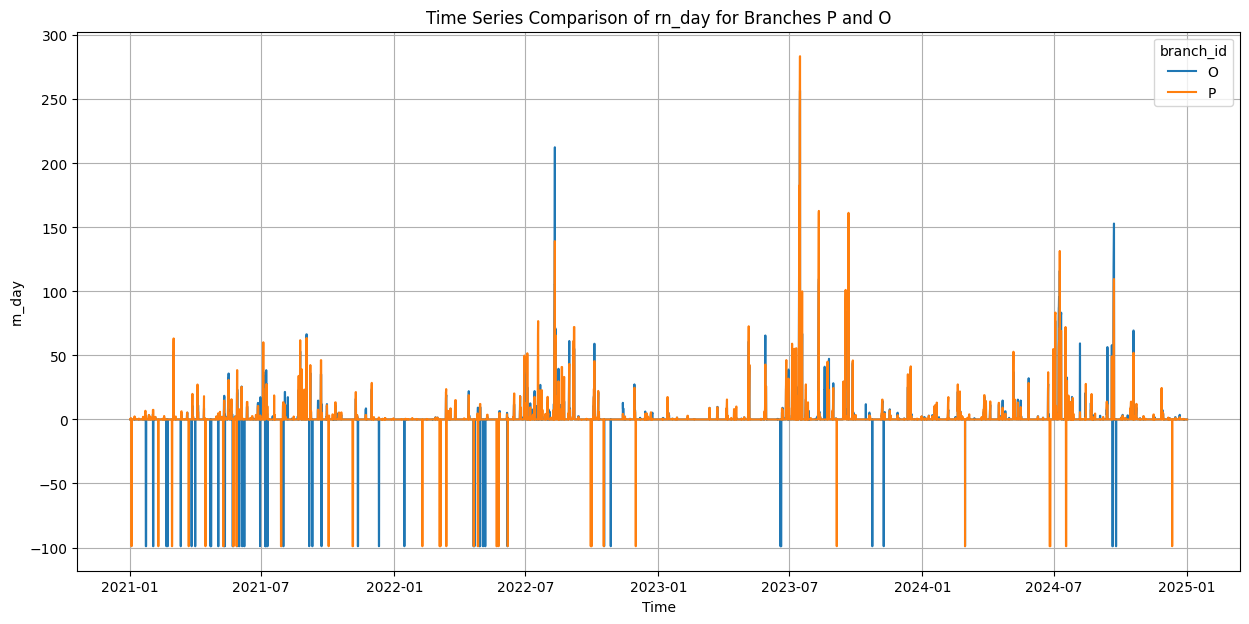

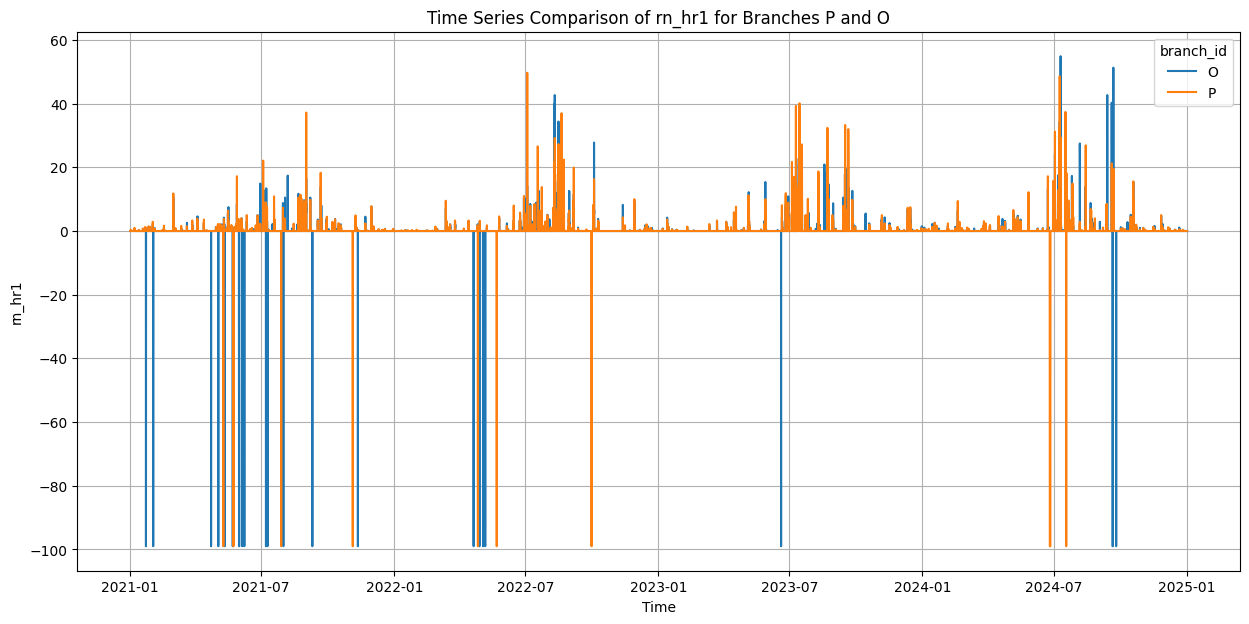

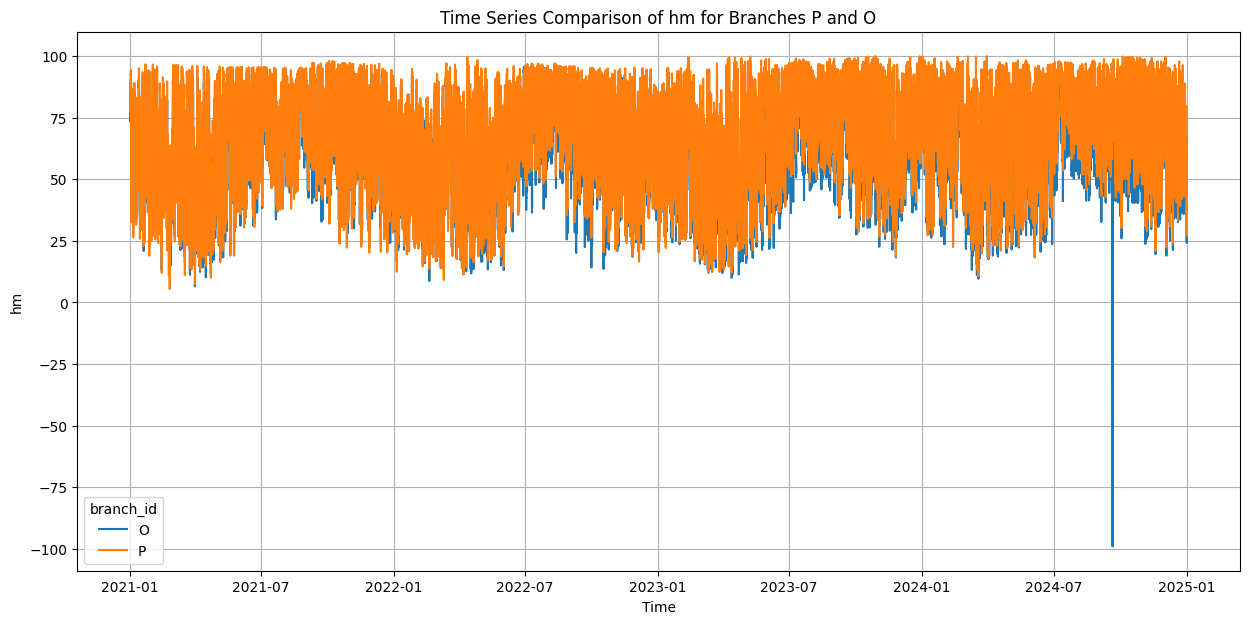

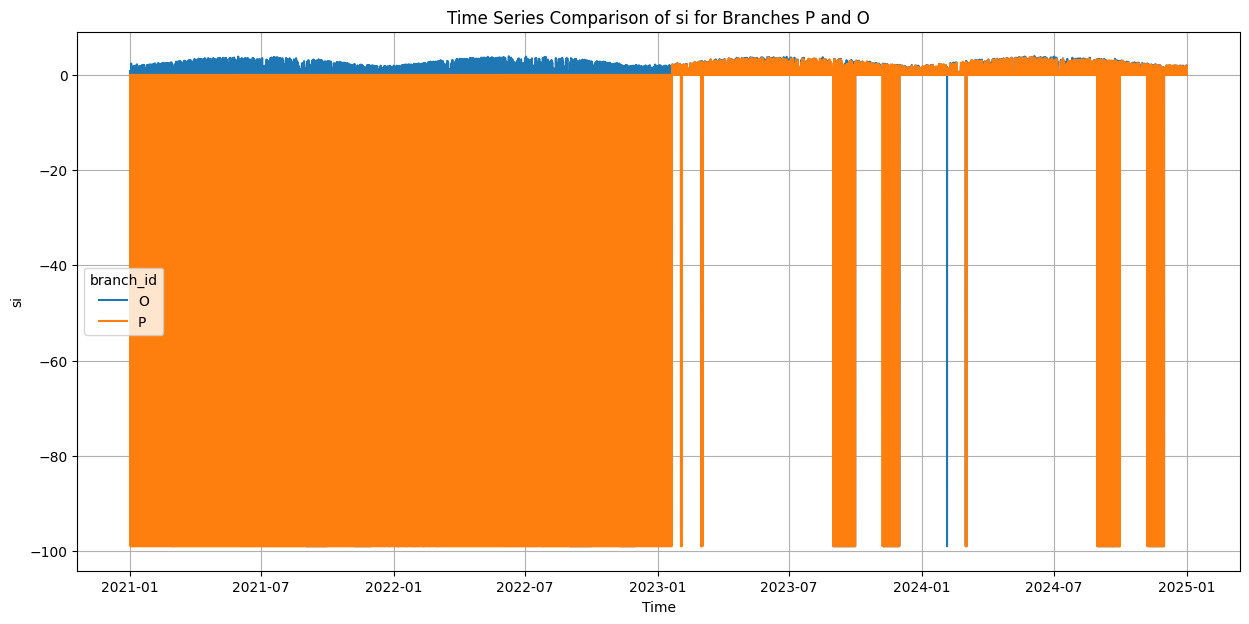

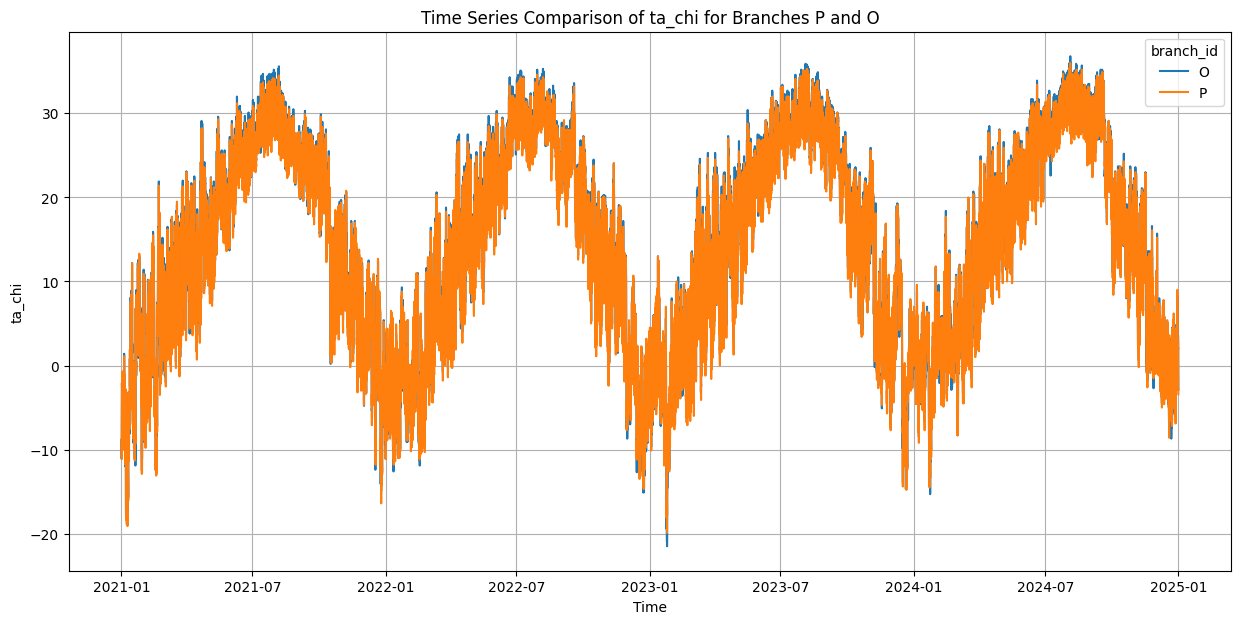

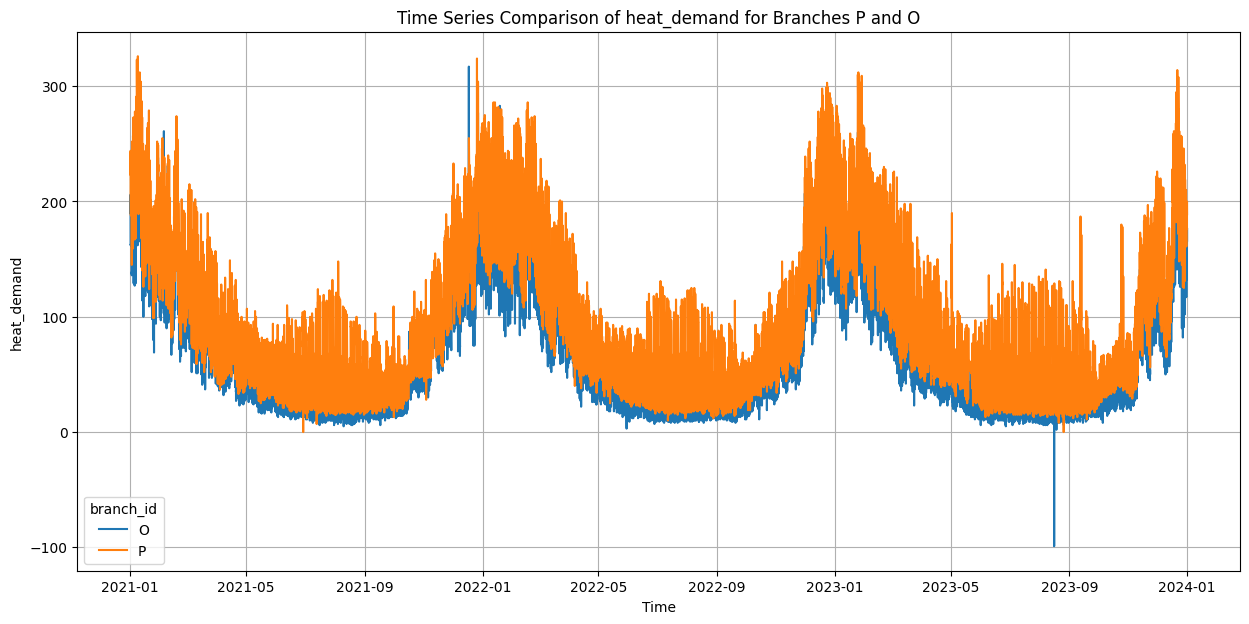

Descriptive Statistics for Branches P and O:

Branch P:


,ta,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,26279.000000
mean,13.720230,1.380499,1.296335,-0.057937,68.048200,-25.373806,14.020092,98.550211
std,10.688926,0.975100,14.365157,4.913706,20.676077,43.568218,11.700358,65.794263
min,-18.400000,0.000000,-99.000000,-99.000000,5.500000,-99.000000,-19.900000,0.000000
25%,5.000000,0.700000,0.000000,0.000000,53.400000,-99.000000,4.200000,50.000000
50%,14.700000,1.200000,0.000000,0.000000,70.000000,0.000000,15.000000,77.000000
75%,22.900000,1.900000,0.000000,0.000000,86.200000,0.010000,24.500000,138.000000
max,35.000000,7.600000,283.700000,49.700000,100.000000,3.780000,36.000000,326.000000



Branch O:


,ta,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,26279.000000
mean,14.655238,1.337500,0.670545,-0.100575,61.139911,-0.091433,14.498902,71.496328
std,11.179312,2.402632,15.531643,5.224684,18.976370,8.467398,11.895425,57.713086
min,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-21.500000,-99.000000
25%,5.800000,0.700000,0.000000,0.000000,47.700000,0.000000,4.500000,27.000000
50%,15.800000,1.200000,0.000000,0.000000,62.500000,0.000000,15.600000,45.000000
75%,24.100000,1.900000,0.000000,0.000000,76.400000,1.050000,25.100000,109.000000
max,36.400000,8.500000,256.800000,54.900000,95.700000,3.920000,36.800000,317.000000


In [ ]:
# 1. 원본 데이터프레임(df)에서 지점 'P'와 'O'만 포함하도록 필터링
df_P_O = df[df['branch_id'].isin(['P', 'O'])].copy()

# 시계열 그래프를 위해 시간 순으로 정렬
df_P_O = df_P_O.sort_values(by='tm')

# 2. 유사도 계산에 사용된 각 기상 변수에 대해 시계열 그래프를 생성
weather_vars_to_plot = ['ta', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

for var in weather_vars_to_plot:
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df_P_O, x='tm', y=var, hue='branch_id')
    plt.title(f'Time Series Comparison of {var} for Branches P and O')
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.grid(True)
    plt.show()

# 5. (선택) 지점별 기술 통계량 출력
print("Descriptive Statistics for Branches P and O:")
for branch in ['P', 'O']:
    print(f"\nBranch {branch}:")
    display(df_P_O[df_P_O['branch_id'] == branch][weather_vars_to_plot].describe())

각 지역 간의 유사성은 'ta', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi', 'heat_demand' 등 7가지 기상 관련 변수 전반에 걸친 평균 피어슨 상관계수를 기반으로 계산되었습니다.
'O' 지역이 'P' 지역과 가장 높은 유사성 점수를 보였으며, 평균 피어슨 상관계수는 0.6578이었습니다.
'P' 지역과 'O' 지역에 대한 지정된 기상 변수의 시계열 플롯과 기술 통계가 생성되어 유사성을 뒷받침하는 시각적 및 정량적 증거를 제공했습니다.
통찰 또는 다음 단계

'P' 지역과 'O' 지역 간의 강한 상관관계는 한 지역에 대한 날씨 관련 분석 또는 예측을 다른 지역에 적용하거나 조정할 수 있음을 시사합니다.
'P' 지역과 'O' 지역 간의 유사한 기상 환경을 설명할 수 있는 지리적 근접성 또는 기타 공유 특성을 조사합니다.


## 선형보간 12시간 기준

['ta', 'ta_chi', 'hm', 'ws', 'rn_hr1']열에 대해서
*   <Train(21,22,23)>  interpolate ‘both’
*   <Test(24)> interpolate ‘forward’


In [ ]:
# 필요한 열
cols_to_interpolate = ['ta', 'ta_chi', 'hm', 'ws', 'rn_hr1']

# tm을 datetime으로 변환하고 인덱스로 설정
df['tm'] = pd.to_datetime(df['tm'])
df = df.set_index('tm')

# -99를 NaN으로 변환
df[cols_to_interpolate] = df[cols_to_interpolate].replace(-99, np.nan)

# 연도별 구분 컬럼 추가
df['year'] = df.index.year

# 보간 함수 정의
def interpolate_limited(group):
    # 2023년 이하 (train) 구간
    train = group[group['year'] <= 2023].copy()
    # 2024년 이상 (test) 구간
    test = group[group['year'] >= 2024].copy()

    for col in cols_to_interpolate:
        # train: both 방향 보간
        train[col] = train[col].interpolate(method='time', limit=6, limit_direction='both')
        # test: forward 방향 보간
        test[col] = test[col].interpolate(method='time', limit=6, limit_direction='forward')

        # 나머지 결측값은 -99로 대체
        train[col] = train[col].fillna(-99)
        test[col] = test[col].fillna(-99)

    return pd.concat([train, test]).sort_index()

# branch_id별로 적용
df = df.groupby('branch_id', group_keys=False).apply(interpolate_limited)

In [ ]:
df.head()

,month,day,hour,weekday,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year
tm,,,,,,,,,,,,,,,
2021-01-01 01:00:00,1,1,1,4,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,281.0,2021
2021-01-01 01:00:00,1,1,1,4,B,-8.7,91.5,0.4,0.0,0.0,-99.0,0.0,-10.5,739.0,2021
2021-01-01 01:00:00,1,1,1,4,C,-7.2,320.3,0.6,0.0,0.0,57.5,0.0,-8.1,663.0,2021
2021-01-01 01:00:00,1,1,1,4,D,-7.0,282.3,0.9,0.0,0.0,-99.0,0.0,-8.1,382.0,2021
2021-01-01 01:00:00,1,1,1,4,E,-7.0,282.3,0.9,0.0,0.0,-99.0,0.0,-8.1,115.0,2021


In [ ]:
df = df.reset_index()  # tm을 인덱스에서 다시 컬럼으로

## P지역과 기상환경 가장 유사한 환경인 O지역으로 si열 보간(피어슨 상관계수)


✅ P 지역 train의 이상치는 O 지역 train의 같은 시각에서 가져옴

✅ P 지역 test의 이상치는 O 지역 test의 같은 시각에서 가져옴

✅ 즉, 시점 구간을 넘지 않고 같은 시간대끼리만 매칭

✅ Data Leakage를 막기 위해, 21년부터 23년의 데이터만 보간하기로 결정

In [ ]:
# 연도 필터링: train 데이터만 사용
df_train = df[df['tm'].dt.year <= 2023]

In [ ]:
# 1. train 중 'P' 지역 & si == -99인 경우
df_P_si_neg_99 = df_train[(df_train['branch_id'] == 'P') & (df_train['si'] == -99)]

In [ ]:
# 2. 그 시점(tm)만 추출
tm_values_P_neg_99 = df_P_si_neg_99['tm']

In [ ]:
# 3. 같은 시점의 'O' 지역 값 추출 (전체 df에서)
df_O_matching_tm = df[(df['tm'].isin(tm_values_P_neg_99)) & (df['branch_id'] == 'O')]

In [ ]:
# 4. 'P' 지역 복사 + 'O'의 si 대입
df_P_si_replaced = df_P_si_neg_99.copy()
df_P_si_replaced['si'] = df_O_matching_tm['si'].values

In [ ]:
# 5. 딕셔너리로 만들기
replaced_si_dict = df_P_si_replaced.set_index('tm')['si'].to_dict()

In [ ]:
# 6. 전체 df에 적용: 단, 2023년까지, branch_id=='P', si==-99인 경우만 대체
df['si'] = df.apply(
    lambda row: replaced_si_dict[row['tm']] if (
        row['branch_id'] == 'P' and
        row['si'] == -99 and
        row['tm'] in replaced_si_dict and
        row['tm'].year <= 2023
    ) else row['si'],
    axis=1
)

In [ ]:
# df 데이터프레임에서 branch_id가 'P'이고 si 값이 -99인 행을 필터링합니다.
df_P_si_neg_99_current = df[(df['branch_id'] == 'P') & (df['si'] == -99)]

# 결과 출력
display(df_P_si_neg_99_current.head())

# 해당 행의 개수도 확인합니다.
print(f"df에서 P지역의 -99인 si 값 데이터 개수: {df_P_si_neg_99_current.shape[0]}")

,tm,month,day,hour,weekday,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year
27033,2021-03-01 07:00:00,3,1,7,0,P,7.6,81.5,2.0,2.2,1.2,91.7,-99.0,6.8,110.0,2021
27489,2021-03-02 07:00:00,3,2,7,1,P,1.1,298.9,1.3,0.0,0.0,89.3,-99.0,1.2,162.0,2021
110918,2021-09-01 06:00:00,9,1,6,2,P,23.2,119.7,1.2,25.6,11.1,93.8,-99.0,26.2,21.0,2021
111374,2021-09-02 06:00:00,9,2,6,3,P,21.0,76.1,2.0,0.0,0.0,86.4,-99.0,23.4,23.0,2021
111830,2021-09-03 06:00:00,9,3,6,4,P,19.1,94.3,1.0,0.0,0.0,86.1,-99.0,21.1,21.0,2021


df에서 P지역의 -99인 si 값 데이터 개수: 244


In [ ]:
df.head()

,tm,month,day,hour,weekday,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year
0,2021-01-01 01:00:00,1,1,1,4,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,281.0,2021
1,2021-01-01 01:00:00,1,1,1,4,B,-8.7,91.5,0.4,0.0,0.0,-99.0,0.0,-10.5,739.0,2021
2,2021-01-01 01:00:00,1,1,1,4,C,-7.2,320.3,0.6,0.0,0.0,57.5,0.0,-8.1,663.0,2021
3,2021-01-01 01:00:00,1,1,1,4,D,-7.0,282.3,0.9,0.0,0.0,-99.0,0.0,-8.1,382.0,2021
4,2021-01-01 01:00:00,1,1,1,4,E,-7.0,282.3,0.9,0.0,0.0,-99.0,0.0,-8.1,115.0,2021


## not P지역 si열에 대해 선형보간

In [ ]:
import pandas as pd
import numpy as np

# 1. -99를 임시 결측값으로 변경
df['si'] = df['si'].replace(-99.0, np.nan)

# 2. 시간 기준 정렬 및 인덱스 설정
df = df.sort_values('tm').set_index('tm')

# 3. branch_id가 P가 아닌 데이터
non_P = df['branch_id'] != 'P'

# 4. 2023년 이전 → both 방식 보간 (limit=3)
pre_2023 = (df.index <= pd.Timestamp('2023-12-31')) & non_P
df.loc[pre_2023, 'si'] = df.loc[pre_2023, 'si'].interpolate(
    method='time', limit=12, limit_direction='both'
)

# 5. 2024년 이후 → forward 방식 보간 (limit=12)
post_2024 = (df.index >= pd.Timestamp('2024-01-01')) & non_P
df.loc[post_2024, 'si'] = df.loc[post_2024, 'si'].interpolate(
    method='time', limit=12, limit_direction='forward'
)

# 6. 보간되지 않고 여전히 NaN인 값들 → 다시 -99.0으로 복원
df['si'] = df['si'].fillna(-99.0)

# 7. 인덱스 복원
df = df.reset_index()

In [ ]:
import pandas as pd
import string

# 분석할 열 목록
cols_to_analyze = ['ta', 'ta_chi', 'hm', 'wd', 'ws', 'si', 'rn_day', 'rn_hr1', 'heat_demand']

# 결과를 저장할 딕셔너리
neg_99_counts_by_branch_and_col = {}

# 'A'부터 'S'까지의 branch_id 리스트 생성
branches = list(string.ascii_uppercase[:19])

# 각 branch_id와 열에 대해 -99 값 개수 계산
for branch in branches:
    neg_99_counts_by_branch_and_col[branch] = {}
    for col in cols_to_analyze:
        count = df[(df['branch_id'] == branch) & (df[col] == -99)].shape[0]
        neg_99_counts_by_branch_and_col[branch][col] = count

# 딕셔너리를 데이터프레임으로 변환
neg_99_summary_df = pd.DataFrame.from_dict(neg_99_counts_by_branch_and_col, orient='index')

# 결과 출력
print("Number of rows with -99 value by branch_id and selected column:")
display(neg_99_summary_df)

Number of rows with -99 value by branch_id and selected column:


,ta,ta_chi,hm,wd,ws,si,rn_day,rn_hr1,heat_demand
A,0,0,0,32,0,33,345,129,2
B,164,0,5869,785,377,6,361,189,0
C,0,0,0,252,52,13,297,78,0
D,4179,0,8135,6584,5821,41,4968,4461,2
E,4179,0,8135,6584,5821,40,4968,4461,9
F,2571,0,2790,2877,2619,35,3178,2738,1
G,12,0,71,1017,47,35,1262,628,0
H,12,0,71,1017,47,27,1262,628,0
I,74,0,3726,414,75,13,173,88,0
J,553,0,615,700,507,0,1065,666,2


In [ ]:
# 풍향 -9.9 → NaN 처리
df['wd'] = df['wd'].replace(-9.9, np.nan)

In [ ]:
# 이상치 -99 → NaN 처리 (전체 컬럼 대상)
df = df.replace(-99, np.nan)

## 파생변수 생성

In [ ]:
# 사이클링 인코딩
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [ ]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [ ]:
def classify_season(month):
  if month in [12, 1, 2]:
    return 'Winter'
  elif month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8, 9]:
    return 'Summer'
  else:
    return 'Autumn' #10, 11

df['season'] = df['month'].apply(classify_season)

In [ ]:
df['wd_sin'] = np.sin(2 * np.pi * df['wd'] / 360)
df['wd_cos'] = np.cos(2 * np.pi * df['wd'] / 360)

In [ ]:
# 파생변수 만들고, 기존 변수는 삭제
df = df.drop(columns=['month', 'day', 'hour', 'wd', 'ta'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666216 entries, 0 to 666215
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           666216 non-null  datetime64[ns]
 1   weekday      666216 non-null  int32         
 2   branch_id    666216 non-null  object        
 3   ws           649200 non-null  float64       
 4   rn_day       643179 non-null  float64       
 5   rn_hr1       649651 non-null  float64       
 6   hm           623338 non-null  float64       
 7   si           665729 non-null  float64       
 8   ta_chi       666216 non-null  float64       
 9   heat_demand  499278 non-null  float64       
 10  year         666216 non-null  int32         
 11  month_sin    666216 non-null  float64       
 12  month_cos    666216 non-null  float64       
 13  hour_sin     666216 non-null  float64       
 14  hour_cos     666216 non-null  float64       
 15  season       666216 non-null  obje

In [ ]:
df.head()

,tm,weekday,branch_id,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,month_sin,month_cos,hour_sin,hour_cos,season,wd_sin,wd_cos
0,2021-01-01 01:00:00,4,A,0.5,0.0,0.0,68.2,0.0,-8.2,281.0,2021,0.5,0.866025,0.258819,0.965926,Winter,9.792228e-01,0.202787
1,2021-01-01 01:00:00,4,S,0.0,0.0,0.0,86.7,0.0,-9.5,13.0,2021,0.5,0.866025,0.258819,0.965926,Winter,-2.449294e-16,1.000000
2,2021-01-01 01:00:00,4,R,1.9,0.0,0.0,92.4,0.0,-6.0,37.0,2021,0.5,0.866025,0.258819,0.965926,Winter,2.739592e-01,0.961741
3,2021-01-01 01:00:00,4,Q,0.6,0.0,0.0,NaN,0.0,-11.7,118.0,2021,0.5,0.866025,0.258819,0.965926,Winter,8.625137e-01,0.506034
4,2021-01-01 01:00:00,4,P,1.0,0.0,0.0,88.0,0.0,-8.8,242.0,2021,0.5,0.866025,0.258819,0.965926,Winter,-5.948228e-01,0.803857


In [ ]:
# 적용 열
weather_cols = ['ws', 'hm', 'ta_chi', 'rn_hr1', 'si']

# 이동 평균
ma_windows = [3, 6, 12, 24, 48, 72]
for col in weather_cols:
    for w in ma_windows:
        df[f'{col}_ma{w}'] = df.groupby('branch_id')[col].transform(lambda x: x.rolling(w, min_periods=1).mean())

# lag 변수
lag_steps = [1, 2, 3]
for col in weather_cols:
    for l in lag_steps:
        df[f'{col}_lag_{l}'] = df.groupby('branch_id')[col].shift(l)

In [ ]:
# 교호작용 변수
# 1. 계절성과 하루 시간대의 결합 주기성
# 2. 직전 일사량과 현재 체감온도의 곱
# 3. 기온과 강수량의 차이로 습냉 환경 반영
df['month_hour_interaction'] = df['month_sin'] * df['hour_sin']
df['si_ta_interaction'] = df['si_lag_1'] * df['ta_chi']
df['ta_rn_diff'] = df['ta_chi'] - df['rn_hr1']

In [ ]:
# 범주형 변수로 변환
df['branch_id'] = df['branch_id'].astype('category')
df['season'] = df['season'].astype('category')
df['weekday'] = df['weekday'].astype('category')

In [ ]:
# 2. train 데이터 (2021~2023)만 추출
df_train = df[df['tm'].dt.year <= 2023]

# 3. branch_id별 heat_demand 평균 계산 및 정렬
branch_mean = (
    df_train
      .groupby('branch_id', as_index=False)['heat_demand']
      .mean()
      .sort_values('heat_demand', ascending=True)
      .reset_index(drop=True)
      .round(2)
)

# 4. ordered_branch_id 부여
branch_mean['ordered_branch_id'] = range(len(branch_mean))

# 5. branch_id → ordered_branch_id 매핑 딕셔너리 생성
id_map = dict(zip(branch_mean['branch_id'], branch_mean['ordered_branch_id']))

# 6. 전체 df에 매핑 적용 (test 포함, 누수 없음)
df['branch_id_reordered'] = df['branch_id'].map(id_map)

# ✅ 확인: branch_id별로 잘 매핑되었는지 출력 (선택)
print(branch_mean[['branch_id', 'ordered_branch_id', 'heat_demand']])

   branch_id  ordered_branch_id  heat_demand
0          S                  0        11.32
1          R                  1        15.25
2          L                  2        24.84
3          M                  3        36.32
4          K                  4        52.65
5          Q                  5        55.58
6          E                  6        58.33
7          F                  7        67.81
8          O                  8        71.50
9          I                  9        77.36
10         N                 10        84.27
11         J                 11        85.77
12         P                 12        98.55
13         A                 13       106.94
14         H                 14       134.98
15         D                 15       158.48
16         G                 16       205.48
17         B                 17       227.79
18         C                 18       248.29


In [ ]:
# 1. train 데이터만 사용 (데이터 누수 방지)
df_train = df[df['tm'].dt.year <= 2023]

# 2. season별 평균 heat_demand 계산 및 정렬
season_mean = (
    df_train
      .groupby('season', as_index=False)['heat_demand']
      .mean()
      .sort_values('heat_demand', ascending=True)
      .reset_index(drop=True)
      .round(2)
)

# 3. ordinal 인코딩 부여
season_mean['ordered_season'] = range(len(season_mean))

# 4. 매핑 딕셔너리 생성
season_map = dict(zip(season_mean['season'], season_mean['ordered_season']))

# 5. 전체 데이터프레임에 매핑 적용
df['season_reordered'] = df['season'].map(season_map)

# ✅ 확인
print(season_mean[['season', 'ordered_season', 'heat_demand']])

   season  ordered_season  heat_demand
0  Summer               0        38.18
1  Spring               1        79.14
2  Autumn               2        82.23
3  Winter               3       200.43


In [ ]:
df['branch_id_reordered'] = df['branch_id_reordered'].astype(int)  # 또는 float

In [ ]:
df['branch_id_reordered'].isna().sum()

np.int64(0)

In [ ]:
df['season_reordered'] = df['season_reordered'].astype(int)  # 또는 float

In [ ]:
df['season_reordered'].isna().sum()

np.int64(0)

In [ ]:
# 조건: 2023-12-31 이하 & heat_demand가 결측치
condition = (df['tm'] <= '2023-12-31') & (df['heat_demand'].isna())

# 해당 조건을 만족하는 행 제거
df = df[~condition]

In [ ]:
print("삭제된 행 수:", condition.sum())

삭제된 행 수: 23


In [ ]:
df = df.set_index('tm')

In [ ]:
df = df.sort_index()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 666193 entries, 2021-01-01 01:00:00 to 2025-01-01 00:00:00
Data columns (total 67 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   weekday                 666193 non-null  category
 1   branch_id               666193 non-null  category
 2   ws                      649179 non-null  float64 
 3   rn_day                  643158 non-null  float64 
 4   rn_hr1                  649630 non-null  float64 
 5   hm                      623321 non-null  float64 
 6   si                      665706 non-null  float64 
 7   ta_chi                  666193 non-null  float64 
 8   heat_demand             499278 non-null  float64 
 9   year                    666193 non-null  int32   
 10  month_sin               666193 non-null  float64 
 11  month_cos               666193 non-null  float64 
 12  hour_sin                666193 non-null  float64 
 13  hour_cos                6

## 상관계수 & 정보 중복 고려한 features 제거

중복 여부 판단 branch_id와 branch_id_reordered

In [ ]:
df_corr = df[['branch_id_reordered']].copy()
df_corr['branch_id_code'] = df['branch_id'].astype('category').cat.codes
print(df_corr.corr())

                     branch_id_reordered  branch_id_code
branch_id_reordered             1.000000       -0.701762
branch_id_code                 -0.701762        1.000000


In [ ]:
df_corr = df[['season_reordered']].copy()

# season이 category라면 정수형 코드로 변환
df_corr['season_code'] = df['season'].astype('category').cat.codes

# 상관계수 계산
corr_value = df_corr.corr().loc['season_reordered', 'season_code']
print(f"season_code vs. season_reordered 상관계수: {corr_value:.4f}")

season_code vs. season_reordered 상관계수: 0.2247


상관계수 ≥ 0.95 또는 SHAP top + 상관계수 중복변수 제거

In [ ]:
ta_chi_cols = [
    'ta_chi', 'ta_chi_ma3', 'ta_chi_ma6', 'ta_chi_ma12',
    'ta_chi_ma24', 'ta_chi_ma48', 'ta_chi_ma72',
    'ta_chi_lag_1', 'ta_chi_lag_2', 'ta_chi_lag_3', 'ta_rn_diff'
]

si_cols = [
    'si', 'si_ma3', 'si_ma6', 'si_ma12', 'si_ma24', 'si_ma48', 'si_ma72',
    'si_lag_1', 'si_lag_2', 'si_lag_3', 'si_ta_interaction'
]

In [ ]:
ta_chi_corr = df[ta_chi_cols].corr().round(4)
si_corr = df[si_cols].corr().round(4)

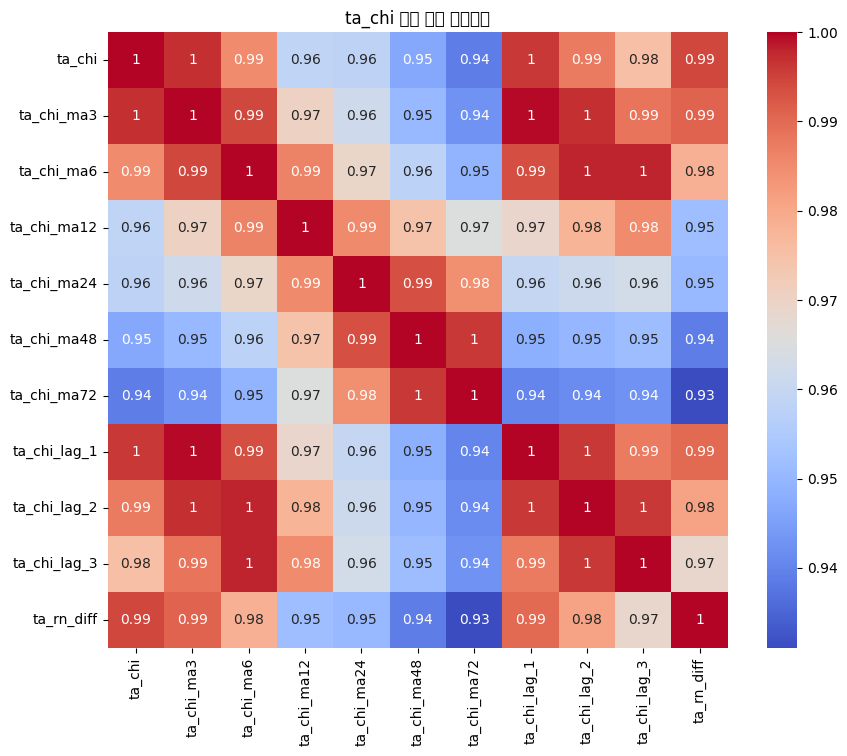

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(ta_chi_corr, annot=True, cmap='coolwarm')
plt.title("ta_chi 관련 변수 상관계수")
plt.show()

In [ ]:
drop_cols = [
    # ta_chi 정보 중복 제거
    'ta_chi_ma6', 'ta_chi_ma12',
     'ta_chi_ma48',
    'ta_chi_lag_2', 'ta_chi_lag_3', 'ta_rn_diff',

    # si 중복 중복 제거
    'si_ma12',
    'si_ma48', 'si_lag_1', 'si_lag_3',

    # 기타 제거
    'month_hour_interaction'
]

In [ ]:
df = df.drop(columns=drop_cols)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 666193 entries, 2021-01-01 01:00:00 to 2025-01-01 00:00:00
Data columns (total 56 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   weekday              666193 non-null  category
 1   branch_id            666193 non-null  category
 2   ws                   649179 non-null  float64 
 3   rn_day               643158 non-null  float64 
 4   rn_hr1               649630 non-null  float64 
 5   hm                   623321 non-null  float64 
 6   si                   665706 non-null  float64 
 7   ta_chi               666193 non-null  float64 
 8   heat_demand          499278 non-null  float64 
 9   year                 666193 non-null  int32   
 10  month_sin            666193 non-null  float64 
 11  month_cos            666193 non-null  float64 
 12  hour_sin             666193 non-null  float64 
 13  hour_cos             666193 non-null  float64 
 14  season            

In [ ]:
# ✅ 카테고리 변수
categorical_features = ['branch_id', 'season', 'weekday']

# ✅ 학습/예측용 데이터 분리
train = df.loc['2021-01-01':'2023-12-31']
test = df.loc['2024-01-01':]

X_train = train.drop(columns=['heat_demand'])
y_train = train['heat_demand']
X_test = test.drop(columns=['heat_demand'])

split_date = '2023-07-01'
X_tr = X_train.loc[:split_date]
y_tr = y_train.loc[:split_date]
X_val = X_train.loc[split_date:]
y_val = y_train.loc[split_date:]

In [ ]:
# 각 행에서 하나라도 결측치가 있는지 확인 → 합계
train_na_rows = train.isnull().any(axis=1).sum()
test_na_rows = X_test.isnull().any(axis=1).sum()

print(f"✅ Train 결측치 포함 행 개수: {train_na_rows}")
print(f"✅ Test 결측치 포함 행 개수: {test_na_rows}")

✅ Train 결측치 포함 행 개수: 51704
✅ Test 결측치 포함 행 개수: 11370


# 모델링

In [ ]:
!pip install optuna
!pip install lightgbm

In [ ]:
import optuna
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error

# ✅ Optuna 최적화
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'num_leaves': trial.suggest_int('num_leaves',20, 200),  # 확대
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 300),
        'max_bin': trial.suggest_int('max_bin', 64, 255),
        'device': 'gpu',
        'random_state': 42
    }

    model = LGBMRegressor(**params)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(0)  # 로그 출력 줄이기
    ]
    )

    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# ✅ 최적 모델 학습 (GPU 설정 유지)
best_params = study.best_params

best_model = LGBMRegressor(
    **best_params,
    n_estimators=1000,
    random_state=42,
    device='gpu'
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    categorical_feature=categorical_features,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(50)
    ]
)

# 실제 사용된 트리 수 확인
print("✅ Best iteration:", best_model.best_iteration_)

# test 예측 시 best_iteration_만큼만 사용
y_pred = best_model.predict(X_test, num_iteration=best_model.best_iteration_)

In [ ]:
print(best_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8633188019782692, 'importance_type': 'split', 'learning_rate': 0.0511966821952151, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 127, 'objective': None, 'random_state': 42, 'reg_alpha': 0.029223934642816474, 'reg_lambda': 0.661935406934828, 'subsample': 0.9981801411002584, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'min_data_in_leaf': 141, 'max_bin': 157, 'device': 'gpu'}


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ✅ Train 예측
y_train_pred = best_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# ✅ Validation 예측
y_val_pred = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)

# ✅ 결과 출력
print(f"✅ Train RMSE: {rmse_train:.4f}")
print(f"✅ Train R² Score: {r2_train:.4f}")
print(f"✅ Val RMSE: {rmse_val:.4f}")
print(f"✅ Val R² Score: {r2_val:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
✅ Train RMSE: 8.7186
✅ Train R² Score: 0.9943
✅ Val RMSE: 8.3596
✅ Val R² Score: 0.9930


In [ ]:
test['heat_demand'] = y_pred

In [ ]:
test.head()

,weekday,branch_id,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,...,hm_lag_2,hm_lag_3,ta_chi_lag_1,rn_hr1_lag_1,rn_hr1_lag_2,rn_hr1_lag_3,si_lag_2,si_ta_interaction,branch_id_reordered,season_reordered
tm,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0,L,1.0,0.3,0.0,76.8,0.0,2.3,59.291158,2024,...,72.7,70.0,3.1,0.0,0.0,0.0,0.0,0.0,2,3
2024-01-01,0,M,1.0,0.7,0.0,87.4,0.0,1.9,84.062210,2024,...,78.8,73.1,2.3,0.0,0.0,0.0,0.0,0.0,3,3
2024-01-01,0,N,0.2,0.5,0.0,84.0,0.0,1.1,208.094594,2024,...,75.4,71.9,2.2,0.0,0.0,0.0,0.0,0.0,10,3
2024-01-01,0,K,0.2,2.5,0.0,93.1,0.0,-0.6,92.472369,2024,...,93.7,92.9,-0.3,0.0,0.0,0.0,0.0,-0.0,4,3
2024-01-01,0,P,0.6,1.6,0.0,89.9,0.0,2.7,196.676059,2024,...,87.2,85.2,2.5,0.0,0.0,0.0,0.0,0.0,12,3


In [ ]:
test = test.sort_values(by=["branch_id", "tm"]).reset_index(drop=True)

In [ ]:
test_heat = pd.read_csv(path+'test_heat.csv')

In [ ]:
test_heat = test_heat.drop(columns=['heat_demand'])

In [ ]:
# 기존 test_heat에 heat_deamnd 넣기
test_heat['heat_demand'] = test['heat_demand'].map(lambda x: f"{x:.1f}")

In [ ]:
test_heat.to_csv('0618.csv', index=False)

In [ ]:
!pip install shap

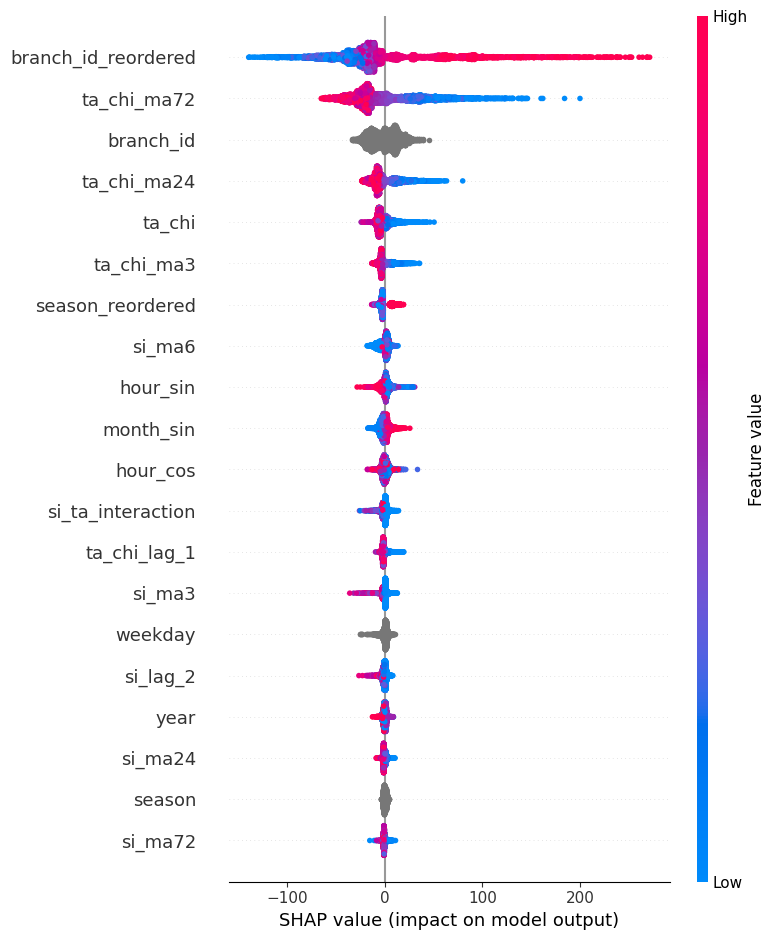

In [ ]:
import shap

# Tree 기반 모델용 explainer
explainer = shap.TreeExplainer(best_model)

# train 데이터 중 일부 샘플에 대해 SHAP 값 계산 (속도 고려)
X_sample = X_train.sample(n=5000, random_state=42)
shap_values = explainer.shap_values(X_sample)

# SHAP 요약 플롯
shap.summary_plot(shap_values, X_sample)

In [ ]:
# SHAP 값은 각 sample x feature의 matrix임 → 절댓값 평균으로 중요도 계산
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# DataFrame으로 정리
shap_importance = pd.DataFrame({
    "feature": X_train.columns,
    "mean_abs_shap": mean_abs_shap
})

# 내림차순 정렬
shap_importance = shap_importance.sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

# 출력 (상위 20개만 보고 싶으면 .head(20))
print(shap_importance.head(60))

                feature  mean_abs_shap
0   branch_id_reordered      42.535225
1           ta_chi_ma72      28.536205
2             branch_id      11.471360
3           ta_chi_ma24      10.805316
4                ta_chi       5.865948
5            ta_chi_ma3       5.321951
6      season_reordered       4.287683
7                si_ma6       3.653286
8              hour_sin       3.542954
9             month_sin       3.334042
10             hour_cos       2.559671
11    si_ta_interaction       2.357873
12         ta_chi_lag_1       1.975922
13               si_ma3       1.855592
14              weekday       1.771618
15             si_lag_2       1.654491
16                 year       1.476998
17              si_ma24       1.294715
18               season       1.063769
19              si_ma72       1.031027
20                   si       0.951169
21              ws_ma72       0.764872
22            month_cos       0.762121
23              hm_ma72       0.452304
24          rn_hr1_ma72  